In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#import warnings
#warnings.filterwarnings("ignore")

<b>Plan :</b>

- prepare data (remove outlier) peut être le faire en EDA.
- splitting in origin train and test set.
- resampled origin et split it in train et valid set (only for simple prediction not for cross or tune).
- first prediction on validation set.
- fine tuning. (origin train set)
- cross validation. (origin train set)
- testing.
- Deep learning à la fin?

<b>Choses à faire:</b>

- Expliquer pourquoi on undersample et oversample ( le papier).
- Expliquer pourquoi resample durant la cross validation.
- Ajouter normalisation !

In [2]:
df =  pd.read_csv('/Users/lucas/Desktop/DS_project/credit_fraud/creditcard.csv')
df = df[['V1', 'V3', 'V7', 'V10', 'V12', 'V14', 'V16', 'V17','V2', 'V4', 'V11', 'Class' ]]

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
def remove_outlier(df, column, th):
    
    outliers = []
    fraud = df[column].loc[df['Class'] == 1].values
   
    q1, q3 = np.percentile(fraud, 25), np.percentile(fraud, 75)
    
    IQR = q3 - q1
    
    IQR_th = IQR * th
    lower, upper = q1 - IQR_th, q3 + IQR_th
    
    print('Lower: {}'.format(lower))
    print('Upper: {}'.format(upper))

    outliers = [x for x in fraud if (x < lower) or (x > upper)]
    print('Feature Outliers for Fraud Cases: {}'.format(len(outliers)))
    df = df.drop(df[(df[column] > upper) | (df[column] < lower)].index)

    print('Number of Instances after outliers removal: {}'.format(len(df)))
    print('----' * 30)
    
    return df,outliers

In [5]:
for i in ['V1', 'V3', 'V7', 'V10', 'V12', 'V14', 'V16', 'V17','V2', 'V4', 'V11']:
    (df_train,_) = remove_outlier(df_train, i, 1.5)



Lower: -14.366091800976793
Upper: 8.240850310600637
Feature Outliers for Fraud Cases: 37
Number of Instances after outliers removal: 227542
------------------------------------------------------------------------------------------------------------------------
Lower: -13.833587941017559
Upper: 5.1082579119982
Feature Outliers for Fraud Cases: 17
Number of Instances after outliers removal: 227515
------------------------------------------------------------------------------------------------------------------------
Lower: -11.283236519193393
Upper: 5.533053706997103
Feature Outliers for Fraud Cases: 19
Number of Instances after outliers removal: 227035
------------------------------------------------------------------------------------------------------------------------
Lower: -11.18299471493925
Upper: 3.52935972878963
Feature Outliers for Fraud Cases: 15
Number of Instances after outliers removal: 225074
---------------------------------------------------------------------------------

In [6]:
X_origin_train = df_train.drop(columns=['Class'])
y_origin_train = df_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [42]:
# model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score, learning_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [8]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)

X_train_resampled, y_train_resampled = over.fit_sample(X_origin_train, y_origin_train)
X_train_resampled, y_train_resampled = under.fit_sample(X_train_resampled, y_train_resampled)


In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [10]:
classifiers = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "XGBoost":XGBClassifier()
}

In [11]:
models = []
train_scores = []
valid_scores = []
valid_precision_scores = []
valid_recall_scores = []

In [12]:
for key, classifier in classifiers.items():
    print('training with ' + key + ' ...')
   
    classifier.fit(X_train, y_train)
    
    models.append(key)
    train_scores.append(classifier.score(X_train, y_train))
    
    y_pred = classifier.predict(X_valid)

    valid_scores.append(accuracy_score(y_pred, y_valid))
    valid_precision_scores.append(precision_score(y_valid, y_pred))
    valid_recall_scores.append(recall_score(y_valid, y_pred))
    
    

training with RandomForest ...
training with LogisticRegression ...
training with DecisionTreeClassifier ...
training with XGBoost ...


In [13]:
results = pd.DataFrame(data={'model':models, 'training score':train_scores,
                             'validation accuracy':valid_scores,
                             'validation precision':valid_precision_scores,
                            'validation recall':valid_recall_scores})
results

,model,training score,validation accuracy,validation precision,validation recall
0,RandomForest,1.000000,0.999121,0.998929,0.998692
1,LogisticRegression,0.938005,0.934467,0.958510,0.859912
2,DecisionTreeClassifier,1.000000,0.992792,0.987236,0.993340
3,XGBoost,0.965607,0.961937,0.979652,0.916042


- faire des barplots

<br>
<b>fine tuning</b>

In [14]:
from sklearn.model_selection import GridSearchCV

In [28]:

params_classifiers = {
    "RandomForest": [{'bootstrap':[False,True],'n_estimators':range(50,150,20),'max_depth':range(1,6,1),
               'max_features':['auto','sqrt','log2']}],
    
    "DecisionTreeClassifier": [{'criterion':['gini','entropy'],'splitter':['best', 'random'],'max_depth':range(1,6,1),
               'max_features':['auto','sqrt','log2']}],
    
    "LogisticRegression": [{'max_iter':range(100,500,100),'C': [ 0.1, 1, 10]}],
    "XGBoost": [{'max_depth': range(1,6,1),'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}]
    
}



In [30]:
estimators = []
best_estimators = []
best_scores = []
for key, classifier in classifiers.items():
    print(key + ' tuning...')
    estimators.append(key)
    
    grid = GridSearchCV(classifier, params_classifiers[key], scoring = 'balanced_accuracy')
    grid.fit(X_train_resampled, y_train_resampled)
    
    best_estimators.append(grid.best_estimator_)
    best_scores.append(grid.best_score_)

RandomForest tuning...
LogisticRegression tuning...
DecisionTreeClassifier tuning...
XGBoost tuning...


In [31]:
tuning = pd.DataFrame(data={'model':estimators, 'best estimator':best_estimators,
                             'best score':best_scores})
tuning

,model,best estimator,best score
0,RandomForest,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.931796
1,LogisticRegression,LogisticRegression(C=0.1),0.923296
2,DecisionTreeClassifier,"DecisionTreeClassifier(criterion='entropy', ma...",0.927644
3,XGBoost,"XGBClassifier(max_depth=5, n_estimators=180)",0.991512


- cross-validation

In [50]:
all_scores = []
for estim in best_estimators:
    pipeline = imbalanced_make_pipeline(over, under, estim)
    all_scores.append(cross_val_score(pipeline, X_origin_train, y_origin_train, cv=10, scoring='balanced_accuracy'))

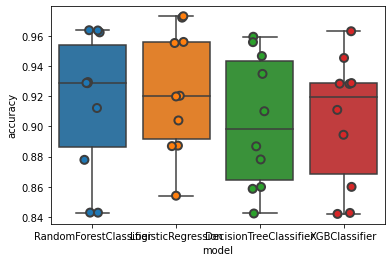

In [51]:
entries = []
for i in range(0, len(all_scores)):
    for score in all_scores[i]:
        entries.append((models[i], score))
        
cv_df = pd.DataFrame(entries, columns=['model','accuracy'])

    
sns.boxplot(x='model', y='accuracy', data=cv_df)
sns.stripplot(x='model', y='accuracy', data=cv_df, 
                          size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

- testing

RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.27      0.89      0.42        98

    accuracy                           1.00     56962
   macro avg       0.64      0.94      0.71     56962
weighted avg       1.00      1.00      1.00     56962



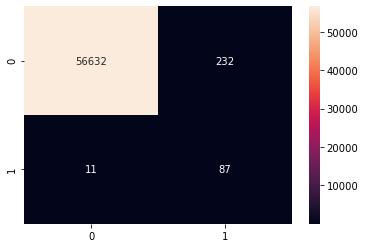

------------------------------
LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.92      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962



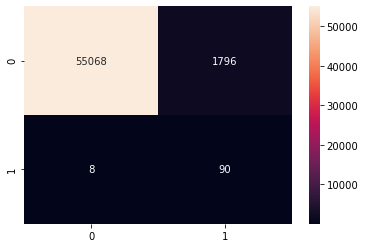

------------------------------
DecisionTreeClassifier
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.83      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.89      0.53     56962
weighted avg       1.00      0.96      0.98     56962



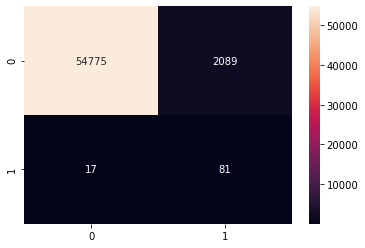

------------------------------
XGBClassifier
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.23      0.89      0.36        98

    accuracy                           0.99     56962
   macro avg       0.61      0.94      0.68     56962
weighted avg       1.00      0.99      1.00     56962



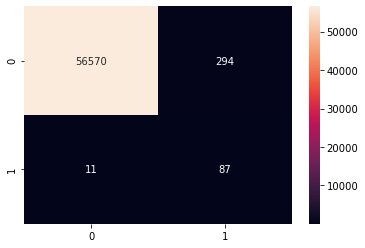

------------------------------


In [43]:

for estim in best_estimators:
    print(estim.__class__.__name__)
    pipeline = imbalanced_make_pipeline(over, under, estim)
    pipeline.fit(X_origin_train, y_origin_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    conf = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf,annot=True,fmt='2.0f')
    plt.show()
    print('-'*30)
    
    